In [1]:
import os
import re
import math
import random
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, average_precision_score, f1_score
import seaborn as sns
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import cloudpickle as pickle
### Pytorch
import torch
import torch.nn as nn
from fastai.tabular import *

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

In [2]:
GLOBAL_SEED = 20210117
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(GLOBAL_SEED) 

# 1. Import data

In [3]:
[data_raw, protein_raw, activities_raw, 
 data_extend, protein_extend, activities_extend] = pickle.load(open('NR.pkl', 'rb'))
#mean, std = data_raw.mean(), data_raw.std() 

In [4]:
cont_names = data_raw.columns
cat_names = []
dep_var = 'Activity'
data_raw['Activity'] = [int(i<1) for i in activities_raw]
data_extend['Activity'] = [int(i<1) for i in activities_extend]
data_raw.shape, data_extend.shape
list(data_raw['Activity']).count(0), list(data_raw['Activity']).count(1)

((6554, 218), (713, 218))

(3129, 3425)

# 2. Split dataset

In [5]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=GLOBAL_SEED)
group_labels = np.array([i.split('_')[0]+'_'+str(data_raw.loc[i, 'Activity']) for i in data_raw.index])
for train_idx, valid_idx in sss.split(data_raw, group_labels):pass
data_train = data_raw.iloc[train_idx, :]
data_test = data_raw.iloc[valid_idx, :]

In [6]:
data_train.shape, data_test.shape, data_extend.shape

((3932, 218), (2622, 218), (713, 218))

# 3. Hyperparameter selection

In [7]:
def get_AUC(data, train_idx, valid_idx, data_test, data_extend, cont_names, dep_var, n_estimators = 101, max_features=0.1, max_depth=None):
    train_data = data.iloc[train_idx, :]
    valid_data = data.iloc[valid_idx, :]
    clf = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, n_jobs=4)
    clf.fit(train_data.loc[:, cont_names], train_data.loc[:, dep_var])
    pre_pro = clf.predict_proba(train_data.loc[:, cont_names])
    pre_pro = [i[1] for i in pre_pro]
    train_auc = roc_auc_score(train_data.loc[:, dep_var], pre_pro)
    pre_pro = clf.predict_proba(valid_data.loc[:, cont_names])
    pre_pro = [i[1] for i in pre_pro]
    valid_auc = roc_auc_score(valid_data.loc[:, dep_var], pre_pro)
    pre_pro = clf.predict_proba(data_test.loc[:, cont_names])
    pre_pro = [i[1] for i in pre_pro]
    test_auc = roc_auc_score(data_test.loc[:, dep_var], pre_pro)
    pre_pro = clf.predict_proba(data_extend.loc[:, cont_names])
    pre_pro = [i[1] for i in pre_pro]
    extend_auc = roc_auc_score(data_extend.loc[:, dep_var], pre_pro)
    return train_auc, valid_auc, test_auc, extend_auc

In [8]:
sss = StratifiedKFold(n_splits=5, shuffle=True, random_state=GLOBAL_SEED)
group_labels = np.array([i.split('_')[0]+'_'+str(data_train.loc[i, 'Activity']) for i in data_train.index])
folds = list(sss.split(data_train, group_labels))

In [9]:
result = []
for n_estimators in [101, 301, 501, 1001]:
    for max_features in [0.1, 0.2, 0.3, 0.4, 0.5]:
        for max_depth in [None, 1, 2, 3, 4, 5]:
            train_aucs = []
            valid_aucs = []
            test_aucs = []
            extend_aucs = []
            for fold in range(5):
                train_idx, valid_idx = folds[fold]
                train_auc, valid_auc, test_auc, extend_auc = get_AUC(data_train, train_idx, valid_idx, data_test, 
                                                                     data_extend, cont_names, dep_var, 
                                                                     n_estimators, max_features, max_depth)
                train_aucs.append(train_auc)
                valid_aucs.append(valid_auc)
                test_aucs.append(test_auc)
                extend_aucs.append(extend_auc)
                result.append([fold, n_estimators, max_features, max_depth, train_auc, valid_auc, test_auc, extend_auc])
            result.append(['Mean', n_estimators, max_features, max_depth, np.array(train_aucs).mean(), 
                           np.array(valid_aucs).mean(), np.array(test_aucs).mean(), np.array(extend_aucs).mean()])
            print(n_estimators, max_features, max_depth, np.array(train_aucs).mean(), 
                  np.array(valid_aucs).mean(), np.array(test_aucs).mean(), np.array(extend_aucs).mean())
result = pd.DataFrame(result, columns=['Fold', 'n_estimators', 'max_features', 'max_depth', 
                                       'Train_AUC', 'Valid_AUC', 'Test_AUC', 'Extend_AUC'])
result.to_csv('Rawdata_RF_Parameters.csv')

101 0.1 None 0.9996886154639121 0.8579305341470427 0.8583968424243837 0.7212329890145925
101 0.1 1 0.6626744157764548 0.6487190942759539 0.6396752058021035 0.5351893753074275
101 0.1 2 0.7134704762042449 0.6890550484308333 0.671694864858562 0.6280644367929169
101 0.1 3 0.7550579203521895 0.7221994626704917 0.7011127305799773 0.6611534677816036
101 0.1 4 0.8041912482204536 0.7536342855645307 0.7379236141881018 0.6744572880800132
101 0.1 5 0.8478405526403753 0.7805217750605831 0.7660207900935145 0.6788293162813577
101 0.2 None 0.9996770340387068 0.8558864389009505 0.8547255777617128 0.7238301360878832
101 0.2 1 0.6572455810381397 0.642044885270463 0.6309548517991651 0.5503508771929824
101 0.2 2 0.7097848043619281 0.6898499262806104 0.6665704507823978 0.6210026233808822
101 0.2 3 0.7601960608261875 0.7261202229375383 0.7057488164921526 0.6604590916543696
101 0.2 4 0.8102333825193592 0.7587200096166427 0.744248501667405 0.6762797179865552
101 0.2 5 0.858290482536046 0.7860806649832927 0.77

In [10]:
result.loc[result['Fold']=='Mean', :].sort_values('Valid_AUC', ascending=False).head(2)

,Fold,n_estimators,max_features,max_depth,Train_AUC,Valid_AUC,Test_AUC,Extend_AUC
365,Mean,501,0.1,NaN,0.999721,0.864316,0.860626,0.724042
545,Mean,1001,0.1,NaN,0.999723,0.863459,0.861319,0.721868


# 4. Oversampling prevents over fitting

In [11]:
def get_AUC_grid(data, train_idx, valid_idx, data_extend, cont_names, dep_var, n_estimators = 101, max_features=0.1, max_depth=None):
    train_data = data.iloc[train_idx, :]
    valid_data = data.iloc[valid_idx, :]
    clf = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, n_jobs=4)
    clf.fit(train_data.loc[:, cont_names], train_data.loc[:, dep_var])
    pre_pro = clf.predict_proba(valid_data.loc[:, cont_names])
    pre_pro = [i[1] for i in pre_pro]
    valid_auc = roc_auc_score(valid_data.loc[:, dep_var], pre_pro)
    pre_pro = clf.predict_proba(data_extend.loc[:, cont_names])
    pre_pro = [i[1] for i in pre_pro]
    extend_auc = roc_auc_score(data_extend.loc[:, dep_var], pre_pro)
    return valid_auc, extend_auc

def oversampling(data_train, N=3000, sigma=0.1, test_size=0.4):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=0) #random_state=0
    protein_train = np.array([i.split('_')[0] for i in data_train.index])
    for train_idx, valid_idx in sss.split(data_train, protein_train):pass
    # sampling
    sample_data = []
    sample_label = []
    sample_proteins = []
    proteins = np.array([i.split('_')[0] for i in data_train.iloc[train_idx, :].index])
    for p in set(proteins):
        temp = data_train.iloc[train_idx, :].loc[proteins==p, :]
        if N-sum(proteins==p)<=0:
            continue
        for i in range(N-sum(proteins==p)):
            rrow = list(temp.iloc[random.choice(range(len(temp.index))), :])
            sample_data.append(rrow)
            sample_label.append(int(rrow[-1]))
            sample_proteins.append(p)
    if len(sample_label) == 0:
        return data_train, train_idx, valid_idx
    sample_data = pd.DataFrame(norm.rvs(np.array(sample_data), scale=sigma), columns=data_train.columns)
    sample_data.index = [sample_proteins[i]+'_OS_'+str(i) for i in range(len(sample_proteins))]
    sample_data[dep_var] = sample_label
    os_data = pd.DataFrame(data_train)
    os_data = os_data.append(sample_data)
    os_train_idx = list(set(range(len(os_data.index)))-set(valid_idx))
    return os_data, os_train_idx, valid_idx

def oversampling_AUC(data, data_extend, cont_names, dep_var, N, sigma, test_size=0.2, 
                     n_estimators = 101, max_features=0.1, max_depth=None):
    os_data, train_idx, valid_idx = oversampling(data, N, sigma, test_size)
    test_auc, extend_auc = get_AUC_grid(os_data, train_idx, valid_idx, data_extend, cont_names, dep_var, 
                                                    n_estimators, max_features, max_depth)
    return test_auc, extend_auc

def oversamping_result(data, data_extend, cont_names, dep_var, n_estimators = 101, max_features=0.1, max_depth=None):
    result = []
    sigma = 0.1
    test_size = np.arange(0.1, 0.51, 0.05)
    N = np.arange(1000, 5001, 500)
    test_size, N = np.meshgrid(test_size, N)
    test_aucs = np.zeros(N.shape)
    extend_aucs = np.zeros(N.shape)
    for i in range(N.shape[0]):
        for j in range(N.shape[1]):
            test_auc, extend_auc = oversampling_AUC(data, data_extend, cont_names, dep_var, N[i][j], sigma, 
                                                    test_size[i][j], n_estimators, max_features, max_depth)
            test_aucs[i][j] = test_auc
            extend_aucs[i][j] = extend_auc
            print(N[i][j], round(1-test_size[i][j], 2), round(test_auc, 3), round(extend_auc, 3))
            result.append([N[i][j], round(1-test_size[i][j], 2), test_auc, extend_auc])
    result = pd.DataFrame(result, columns=['N', 'Train size', 'Test AUC', 'Extend AUC'])
    return N, (1-test_size), test_aucs, extend_aucs, result

In [12]:
n_estimators = 501; max_features=0.1; max_depth=None
N, train_size, test_aucs, extend_aucs, result = oversamping_result(data_raw, data_extend, cont_names, dep_var, 
                                                                  n_estimators=n_estimators, 
                                                                  max_features=max_features, max_depth=max_depth)
pickle.dump([N, train_size, test_aucs, extend_aucs, result], open('NR_surface_RF_n501_f0.1_dNone.pkl', 'wb'))

1000 0.9 0.905 0.739
1000 0.85 0.905 0.741
1000 0.8 0.908 0.755
1000 0.75 0.902 0.752
1000 0.7 0.9 0.732
1000 0.65 0.891 0.744
1000 0.6 0.887 0.75
1000 0.55 0.882 0.726
1000 0.5 0.874 0.746
1500 0.9 0.906 0.771
1500 0.85 0.908 0.766
1500 0.8 0.91 0.764
1500 0.75 0.903 0.749
1500 0.7 0.9 0.743
1500 0.65 0.893 0.743
1500 0.6 0.886 0.736
1500 0.55 0.883 0.748
1500 0.5 0.877 0.753
2000 0.9 0.9 0.778
2000 0.85 0.904 0.744
2000 0.8 0.908 0.766
2000 0.75 0.903 0.762
2000 0.7 0.901 0.762
2000 0.65 0.894 0.76
2000 0.6 0.887 0.762
2000 0.55 0.884 0.753
2000 0.5 0.877 0.75
2500 0.9 0.904 0.766
2500 0.85 0.905 0.775
2500 0.8 0.908 0.771
2500 0.75 0.903 0.761
2500 0.7 0.901 0.758
2500 0.65 0.894 0.751
2500 0.6 0.89 0.757
2500 0.55 0.885 0.751
2500 0.5 0.877 0.749
3000 0.9 0.903 0.76
3000 0.85 0.905 0.781
3000 0.8 0.909 0.779
3000 0.75 0.904 0.766
3000 0.7 0.899 0.76
3000 0.65 0.894 0.76
3000 0.6 0.89 0.76
3000 0.55 0.884 0.751
3000 0.5 0.878 0.75
3500 0.9 0.903 0.771
3500 0.85 0.904 0.761
3500 0.8 

In [17]:
N, train_size, test_aucs, extend_aucs, result = pickle.load(open('NR_surface_RF_n501_f0.1_dNone.pkl', 'rb'))

In [18]:
result.sort_values('Tets AUC', ascending=False).head(2)

,N,Train size,Tets AUC,Extend AUC
11,1500,0.8,0.910346,0.764302
38,3000,0.8,0.908799,0.778529


# 5. Result

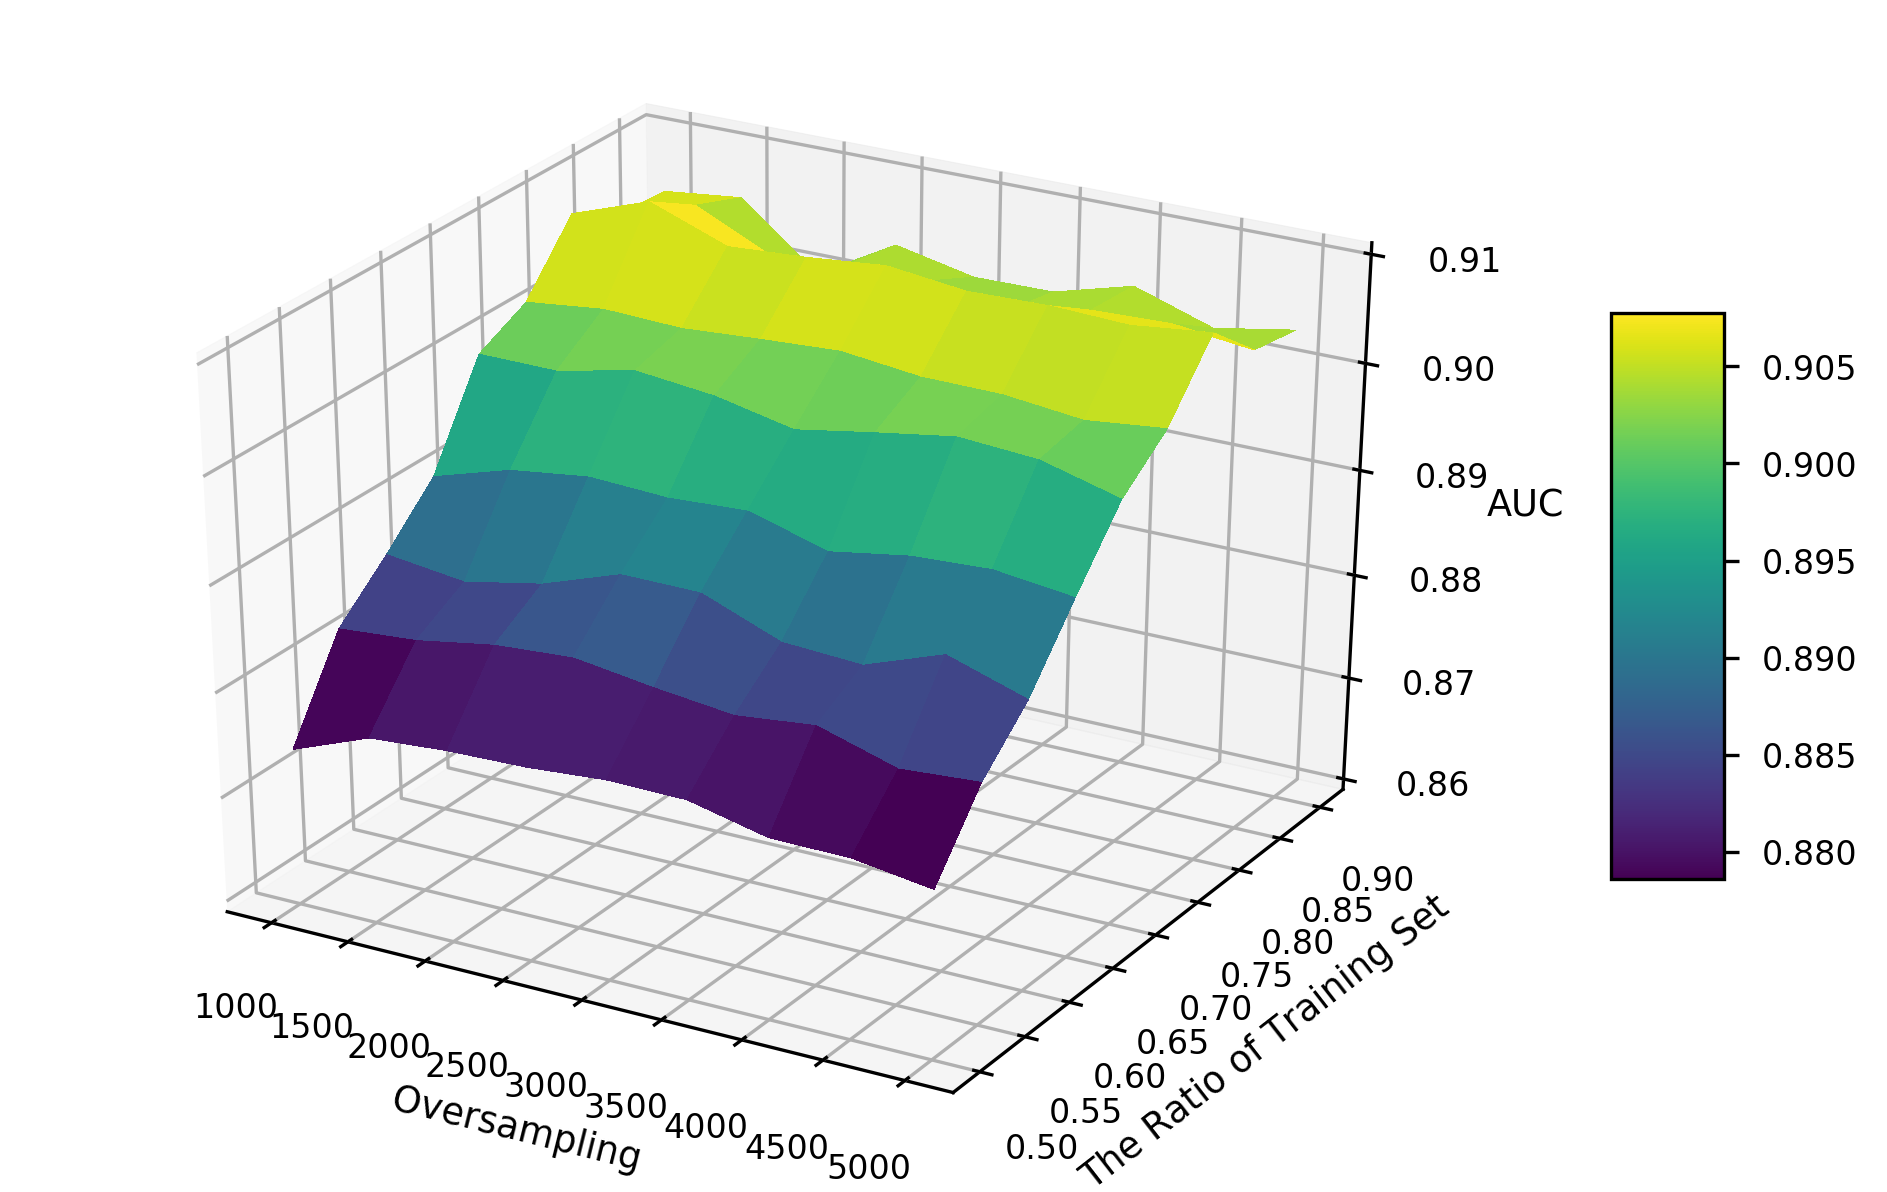

In [19]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import seaborn as sns
import matplotlib.pyplot as plt
#plt.style.available
plt.style.use("seaborn-paper")

fig = plt.figure(1, (8, 5), dpi=300)
ax = fig.gca(projection='3d')
# Plot the surface.
surf = ax.plot_surface(N, train_size, test_aucs, cmap='viridis', #cm.coolwarm
                       linewidth=0, antialiased=False)
_ = ax.set_zlim(0.86, 0.91)
_ = ax.set_xlabel('Oversampling')
_ = ax.set_ylabel('The Ratio of Training Set')
_ = ax.set_zlabel('AUC')
_ = fig.colorbar(surf, shrink=0.5, aspect=5)
_ = plt.show()

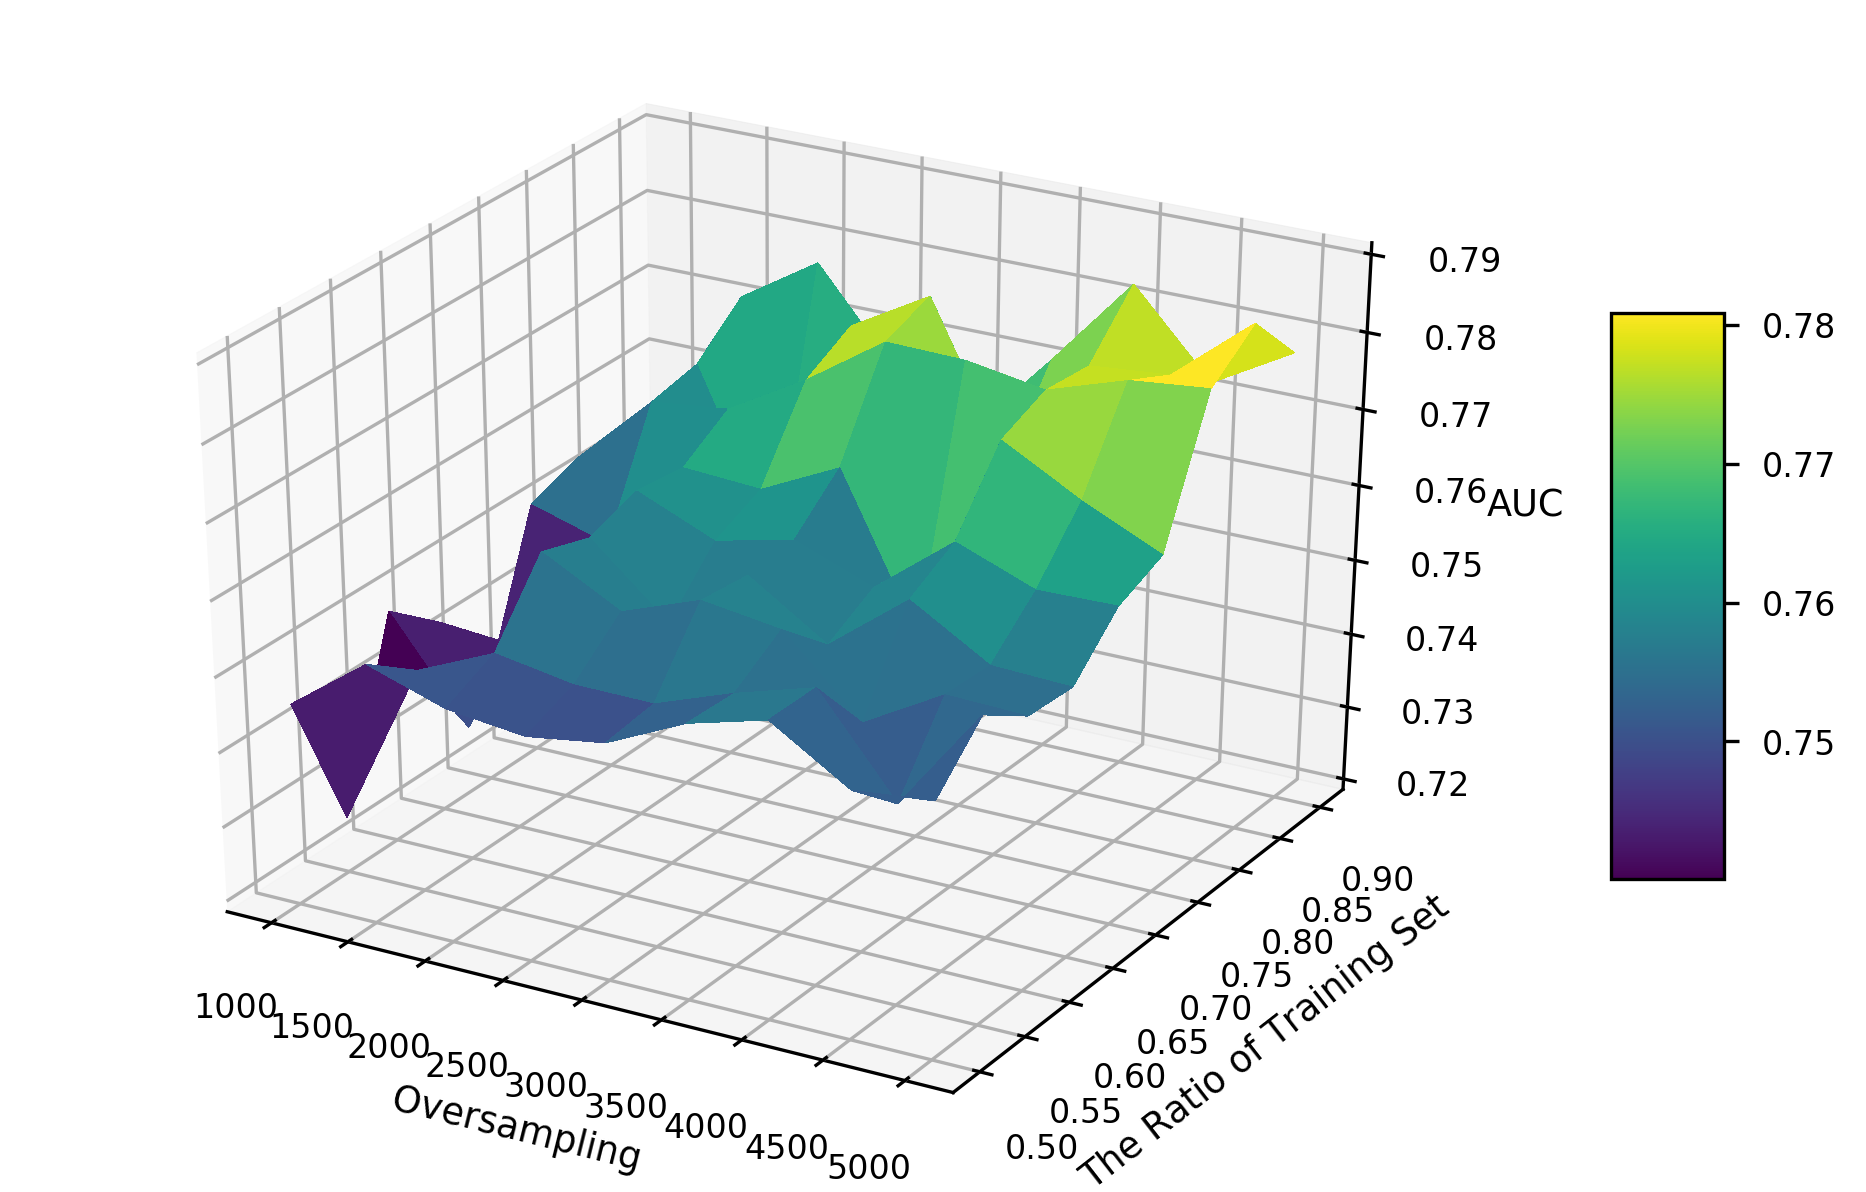

In [20]:
fig = plt.figure(1, (8, 5), dpi=300)
ax = fig.gca(projection='3d')
# Plot the surface.
surf = ax.plot_surface(N, train_size, extend_aucs, cmap='viridis', #cm.coolwarm
                       linewidth=0, antialiased=False)
_ = ax.set_zlim(0.72, 0.79)
_ = ax.set_xlabel('Oversampling')
_ = ax.set_ylabel('The Ratio of Training Set')
_ = ax.set_zlabel('AUC')
_ = fig.colorbar(surf, shrink=0.5, aspect=5)
_ = plt.show()

# 6. Final model

In [7]:
def oversampling_raw(data, N=3000, sigma=0.1):
    # sampling
    sample_data = []
    sample_label = []
    sample_proteins = []
    proteins = np.array([i.split('_')[0] for i in data.index])
    for p in set(proteins):
        temp = data.loc[proteins==p, :]
        if N-sum(proteins==p)<=0:
            continue
        for i in range(N-sum(proteins==p)):
            rrow = list(temp.iloc[random.choice(range(len(temp.index))), :])
            sample_data.append(rrow)
            sample_label.append(int(rrow[-1]))
            sample_proteins.append(p)
    if len(sample_label) == 0:
        return data
    sample_data = pd.DataFrame(norm.rvs(np.array(sample_data), scale=sigma), columns=data.columns)
    sample_data.index = [sample_proteins[i]+'_OS_'+str(i) for i in range(len(sample_proteins))]
    sample_data[dep_var] = sample_label
    os_data = pd.DataFrame(data)
    os_data = os_data.append(sample_data)
    return os_data

In [10]:
result.sort_values('Extend AUC', ascending=False).head(2)
N = 5000
n_estimators = 501; max_features=0.1; max_depth=None

,N,Train size,Tets AUC,Extend AUC
73,5000,0.85,0.904486,0.785666
54,4000,0.90,0.904789,0.782977


In [11]:
data = data_raw.copy()
data = pd.concat([data_raw, data_extend], axis=0, sort=False)
data = oversampling_raw(data, N)

In [12]:
clf = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, n_jobs=4)
_ = clf.fit(data.loc[:, cont_names], data.loc[:, dep_var])

pre_pro = clf.predict_proba(data.loc[:, cont_names])
pre_pro = [i[1] for i in pre_pro]
roc_auc_score(data.loc[:, dep_var], pre_pro)

0.9999897213365911

In [13]:
pre_pro = clf.predict_proba(data_extend.loc[:, cont_names])
pre_pro = [i[1] for i in pre_pro]
roc_auc_score(data_extend.loc[:, dep_var], pre_pro)

0.9994876209214625

In [14]:
pickle.dump([data, clf], open('NR_RF_N5000_n501_f0.1_dNone.pkl', 'wb'))